In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [ ]:
# Importing Training Set
dataset_train = pd.read_csv('/content/gdrive/My Drive/datasets/GOOG.csv')

print(dataset_train.head())

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print(datelist_train)

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

         Date        Open        High  ...       Close   Adj Close   Volume
0  2008-08-22  244.832306  246.515991  ...  244.379013  244.379013  4611500
1  2008-08-25  242.147369  247.572037  ...  240.603165  240.603165  4043600
2  2008-08-26  240.827316  240.827316  ...  236.194687  236.194687  6641100
3  2008-08-27  235.980484  236.528427  ...  233.415100  233.415100  8807000
4  2008-08-28  235.362808  237.335403  ...  236.005386  236.005386  6082000

[5 rows x 7 columns]
[datetime.date(2008, 8, 22), datetime.date(2008, 8, 25), datetime.date(2008, 8, 26), datetime.date(2008, 8, 27), datetime.date(2008, 8, 28), datetime.date(2008, 8, 29), datetime.date(2008, 9, 2), datetime.date(2008, 9, 3), datetime.date(2008, 9, 4), datetime.date(2008, 9, 5), datetime.date(2008, 9, 8), datetime.date(2008, 9, 9), datetime.date(2008, 9, 10), datetime.date(2008, 9, 11), datetime.date(2008, 9, 12), datetime.date(2008, 9, 15), datetime.date(2008, 9, 16), datetime.date(2008, 9, 17), datetime.date(2008, 9, 

In [ ]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (2998, 5).


array([[ 244.832306,  246.515991,  243.82608 ,  244.379013,  244.379013],
       [ 242.147369,  247.572037,  239.850983,  240.603165,  240.603165],
       [ 240.827316,  240.827316,  234.416351,  236.194687,  236.194687],
       ...,
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049],
       [1515.26001 , 1570.290039, 1503.599976, 1565.719971, 1565.719971],
       [1586.98999 , 1586.98999 , 1554.280029, 1558.420044, 1558.420044]])

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

training_set_scaled


array([[-1.03988439, -1.04063569, -1.03585083, -1.04020883, -1.04020883],
       [-1.04718024, -1.03779417, -1.04674835, -1.05045548, -1.05045548],
       [-1.05076726, -1.05594234, -1.06164711, -1.06241891, -1.06241891],
       ...,
       [ 2.42956569,  2.39521192,  2.40355288,  2.40940922,  2.40940922],
       [ 2.41228353,  2.52127252,  2.41775339,  2.54555696,  2.54555696],
       [ 2.60719737,  2.56620745,  2.5566901 ,  2.52574691,  2.52574691]])

In [ ]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want to predict into the future (lag size)
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
  if i < 91:
    print(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    print('___________')
    print(training_set_scaled[i + n_future - 1:i + n_future, 0])
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('_______________________')
print(X_train)

print('_______________________')
print(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

[[-1.03988439 -1.04063569 -1.03585083 -1.04020883]
 [-1.04718024 -1.03779417 -1.04674835 -1.05045548]
 [-1.05076726 -1.05594234 -1.06164711 -1.06241891]
 [-1.06393769 -1.06750945 -1.06949932 -1.06996196]
 [-1.06561611 -1.0653381  -1.06200217 -1.06293262]
 [-1.06932495 -1.07262953 -1.07292701 -1.07711296]
 [-1.05982276 -1.05765795 -1.07416973 -1.07446345]
 [-1.07070563 -1.06823321 -1.07668245 -1.07559895]
 [-1.08252245 -1.08304396 -1.09058428 -1.09472692]
 [-1.10216308 -1.09749276 -1.10331171 -1.10285123]
 [-1.09332413 -1.09684943 -1.13407883 -1.13569995]
 [-1.13237519 -1.12440676 -1.13756111 -1.13744378]
 [-1.13061553 -1.1349954  -1.14482614 -1.14352686]
 [-1.15243538 -1.12077443 -1.14933261 -1.11704511]
 [-1.12284592 -1.1115261  -1.11844263 -1.11175959]
 [-1.1312517  -1.11155291 -1.12566671 -1.11689641]
 [-1.12859868 -1.10175507 -1.1232359  -1.10463559]
 [-1.11165171 -1.11534606 -1.13969144 -1.14308077]
 [-1.13309258 -1.11529248 -1.14370632 -1.10984003]
 [-1.08116889 -1.08461214 -1.09

In [ ]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [ ]:
# (window size, features)
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
                                                              #(window size, 1)
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [ ]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.1798
Epoch 00001: val_loss improved from inf to 0.37703, saving model to weights.h5
9/9 [==============================] - 4s 434ms/step - loss: 0.1798 - val_loss: 0.3770
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.0481
Epoch 00002: val_loss improved from 0.37703 to 0.16107, saving model to weights.h5
9/9 [==============================] - 2s 240ms/step - loss: 0.0481 - val_loss: 0.1611
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.0404
Epoch 00003: val_loss did not improve from 0.16107
9/9 [==============================] - 2s 241ms/step - loss: 0.0404 - val_loss: 0.1806
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.0383
Epoch 00004: val_loss did not improve from 0.16107
9/9 [==============================] - 2s 228ms/step - loss: 0.0383 - val_loss: 0.2606
Epoch 5/30
9/9 [==============================] - ETA: 0s - loss: 0.0376
Epoch 00005: val_loss d

In [ ]:

# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
print(datelist_future)
'''
Remeber, we have datelist_train from begining.
'''
print("___________________________________________________________________________________________")
# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())
print(datelist_future_)
print(len(datelist_future_))

[Timestamp('2020-07-21 00:00:00', freq='D'), Timestamp('2020-07-22 00:00:00', freq='D'), Timestamp('2020-07-23 00:00:00', freq='D'), Timestamp('2020-07-24 00:00:00', freq='D'), Timestamp('2020-07-25 00:00:00', freq='D'), Timestamp('2020-07-26 00:00:00', freq='D'), Timestamp('2020-07-27 00:00:00', freq='D'), Timestamp('2020-07-28 00:00:00', freq='D'), Timestamp('2020-07-29 00:00:00', freq='D'), Timestamp('2020-07-30 00:00:00', freq='D'), Timestamp('2020-07-31 00:00:00', freq='D'), Timestamp('2020-08-01 00:00:00', freq='D'), Timestamp('2020-08-02 00:00:00', freq='D'), Timestamp('2020-08-03 00:00:00', freq='D'), Timestamp('2020-08-04 00:00:00', freq='D'), Timestamp('2020-08-05 00:00:00', freq='D'), Timestamp('2020-08-06 00:00:00', freq='D'), Timestamp('2020-08-07 00:00:00', freq='D'), Timestamp('2020-08-08 00:00:00', freq='D'), Timestamp('2020-08-09 00:00:00', freq='D'), Timestamp('2020-08-10 00:00:00', freq='D'), Timestamp('2020-08-11 00:00:00', freq='D'), Timestamp('2020-08-12 00:00:00'

In [ ]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [ ]:

# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2009-08-05,263.193756
2009-08-06,263.541046
2009-08-07,263.585449


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

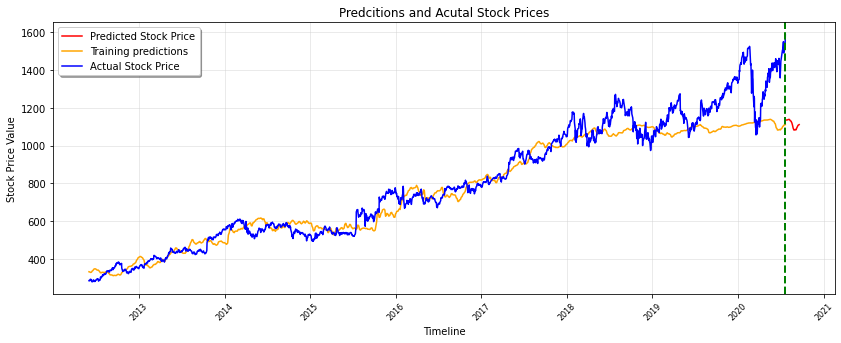

In [ ]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()